In [1]:
#packages
import pandas as pd
import numpy as np
import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from xgboost import XGBRFRegressor

In [2]:
# hide warnings
warnings.filterwarnings('ignore')

In [3]:
def prepare_data():
    df = read_data()
    df = format_columns(df)
    
    df = df.groupby(["zone_idx","day_of_week", "dayflag"], as_index=False).agg({"accessibility_score":"mean", "minutes":"mean"})
    
    return df

In [4]:
def read_data():
    con = sqlite3.connect("fire_data_v4.db")
    cur = con.cursor()
    
    df = pd.read_sql("select calls_for_service.analysis_neighborhoods as neighborhood " \
        ", calls_for_service.call_number " \
        ", calls_for_service.incident_number " \
        ", floating_catchment_output.[index] " \
        ", floating_catchment_output.zone_idx " \
        ", floating_catchment_output.accessibility_score " \
        ", floating_catchment_output.scenario_name " \
        ", calls_for_service.on_scene_dttm " \
        ", calls_for_service.response_dttm   " \
        ", category_mappings.[index] as primary_situation_index " \
        "from floating_catchment_output " \
        "inner join zone_idx_to_incident on  " \
        "zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx " \
        "inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number " \
        "left join fire_incidents AS fi on calls_for_service.incident_number = fi.incident_number " \
        "left join category_mappings on fi.primary_situation = category_mappings.primary_situation " \
        "where calls_for_service.unit_type in ('TRUCK', 'ENGINE') " \
        "and scenario_name = 'baseline'",con = con)
    
    return df

In [5]:
def format_columns(df):
    df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
    df['response_dttm'] = pd.to_datetime(df['response_dttm'])
    df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
    df['minutes'] = (df.arrival_time.dt.seconds) / 60
    df['seconds'] = (df.arrival_time.dt.seconds) 
    df['day_of_week'] = df['on_scene_dttm'].dt.dayofweek
    df['dayflag'] = (df.response_dttm.dt.hour > 5) & (df.response_dttm.dt.hour < 18)

    df = df[df['dayflag'].notna()]
    df = df[df['day_of_week'].notna()]
    
    return df

In [6]:
df = prepare_data()
df.head()

,zone_idx,day_of_week,dayflag,accessibility_score,minutes
0,8,0.0,False,0.000803,7.283333
1,8,0.0,True,0.000803,7.289506
2,8,1.0,False,0.000803,2.916667
3,8,1.0,True,0.000803,14.403333
4,8,2.0,False,0.000803,3.583333


In [7]:
class ModelData:
    x = None
    y = None
    x_train = None
    x_test = None
    y_train = None
    y_test = None

    model = None
    target_to_predict = None
    predictors = None
    XGB = None
    gscv_XGB = None

In [8]:
def configure_sets(md):
    md.predictors = ['zone_idx', 'day_of_week', 'dayflag', 'accessibility_score']
    md.target_to_predict = 'minutes'
    
    md.x = df[md.predictors].values
    md.y = df[md.target_to_predict].values

    #Split the data into training and testing set
    md.x_train, md.x_test, md.y_train, md.y_test = train_test_split(md.x, md.y, test_size = 0.8, random_state = 614)

In [9]:
def create_model(md):    
    #md.model = XGBRFRegressor(n_estimators = 500, subsample = 0.9, colsample_bynode = 1, max_depth = 20, learning_rate = 0.1, min_child_weight = 5)
    #md.model = XGBRFRegressor(n_estimators = 1000, subsample = 0.9, colsample_bynode = 0.2)
    md.model = XGBRFRegressor(n_estimators = 300, subsample = 0.5, colsample_bynode = 0.8, min_child_weight = 3)

    #Printing all the parameters of XGBoost
    print(md.model)

In [10]:
def tune_hyper_parameters(md):
    param_grid = {
        'min_child_weight': [1, 3, 5, 7, 10],
        'subsample': [0.5, 0.7, 0.9, 1],
        'n_estimators': [100, 300, 500, 800, 1000, 2000],
        'colsample_bynode': [0.2, 0.5, 0.8, 1]
    }

    md.gscv_XGB = GridSearchCV(estimator = md.model, param_grid = param_grid)
    md.gscv_XGB.fit(md.x_train, md.y_train)
    
    print(md.gscv_XGB.best_params_)
    
    ##################################################################
    #Runs Results
    ##################################################################
    """#1
    run:
    param_grid = {
        'n_estimators': [100, 1000, 2000]
    }
    
    results:
    {'n_estimators': 1000}
    """
    
    """
    #2 For some reason some parameters mess with the results
    run:
    param_grid = {
        'learning_rate': [0.0001, 0.01, 0.1],
        'max_depth': [10, 20, 50],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7, 0.9],
        'n_estimators': [500, 800, 1000]
    }
    
    result:
    {'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.9}
    
    
    #3
    param_grid = {
        'min_child_weight': [1, 3, 5, 7, 10],
        'subsample': [0.5, 0.7, 0.9, 1],
        'n_estimators': [100, 300, 500, 800, 1000, 2000],
        'colsample_bynode': [0.2, 0.5, 0.8, 1]
    }
    
    {'colsample_bynode': 0.8, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.5}
    """

In [11]:
def fit_data(md):
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.x_train, md.y_train)
    
    prediction = md.XGB.predict(md.x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.x_train)))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')

In [12]:
def predict_using_training_set(md):
    prediction = md.XGB.predict(md.x_test)
    
    training_set_predictions = pd.DataFrame(data = md.x_test, columns = md.predictors)
    training_set_predictions[md.target_to_predict] = md.y_test
    training_set_predictions[('Predicted' + md.target_to_predict)] = prediction
    training_set_predictions.head()
    
    print(training_set_predictions.head(15))
    print(training_set_predictions.tail(15))

In [13]:
def get_accuracy(md):
    y_predict_train = md.XGB.predict(md.x_train)
    y_predict_test = md.XGB.predict(md.x_test)
    
    prediction = md.XGB.predict(md.x_test)
    
    print("Methods Accuracy:")
    print("Accuracy: " + str(md.XGB.score(md.x_train, md.y_train)))
    print("Mean CV Score: " + str(cross_val_score(md.XGB, md.x_train, md.y_train,cv = 10).mean()))
    
    print("Test Accuracy:")
    print(100 - (np.mean(np.abs((md.y_test - prediction)) / np.mean(md.y_test)) * 100))
    print(100 - (np.mean(np.abs((md.y_test - prediction) / md.y_test)) * 100))

In [14]:
model_data = ModelData()

configure_sets(model_data)

In [15]:
create_model(model_data)
#tune_hyper_parameters(model_data)

XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bytree=None, enable_categorical=False, gamma=None,
               gpu_id=None, importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=3,
               missing=nan, monotone_constraints=None, n_estimators=300,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.5,
               tree_method=None, validate_parameters=None, verbosity=None)


R2 Value: 0.358230982530905


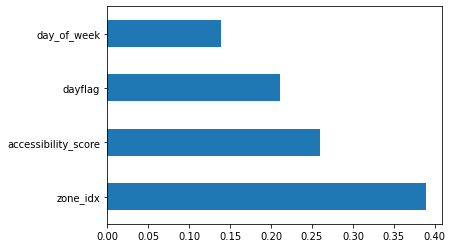

In [16]:
fit_data(model_data)

In [17]:
predict_using_training_set(model_data)
get_accuracy(model_data)

   zone_idx day_of_week dayflag accessibility_score   minutes  \
0       218         1.0   False            0.000304  3.250000   
1        36         2.0    True              0.0002  7.211111   
2       256         2.0   False             0.00032  4.347778   
3       315         2.0    True              0.0005  3.822316   
4       271         0.0   False            0.000485  3.393452   
5       256         5.0    True             0.00032  3.317949   
6       118         2.0    True            0.000549  4.845833   
7       199         5.0    True            0.000304  3.163636   
8       265         3.0    True             0.00021  2.738180   
9       277         4.0   False            0.000331  3.935714   
10       58         0.0    True              0.0002  5.772222   
11       37         4.0   False              0.0002  3.733333   
12      194         6.0    True            0.000683  2.735417   
13      117         4.0    True            0.000549  3.841111   
14      336         4.0  